

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold


The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-01-02 10:06:43--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-01-02 10:06:44 (99.6 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2021-01-02 10:06:44--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

How to load the data:

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [4]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

All training points:

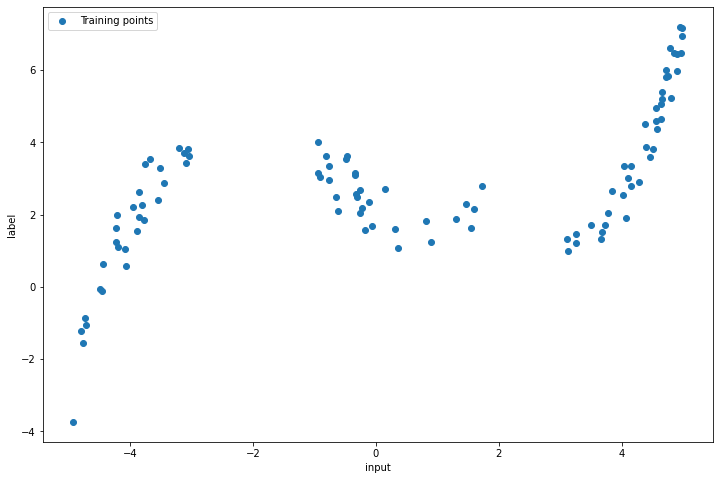

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

## Transformation

In [6]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())

In [7]:
to_tensor = ToTensor()

## Classifier Dataset

In [8]:
class ClassifierDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and store the content in a pandas DataFrame
    self.df = csv_file

  def __len__(self):
    # The length of the dataset
    return len(self.df)

  def __getitem__(self, idx):
    # Our sample is the row at index idx of the dataframe
    row = self.df.iloc[idx]
    # There are 2 inputs 
    sample = (row.input, row.label)
    if self.transform:
        sample = self.transform(sample)
    return sample

In [9]:
train_dataset = ClassifierDataset(train_df,transform=to_tensor)
test_dataset = ClassifierDataset(test_df,transform=to_tensor)

# Network analysis

## Network definition

In [10]:
class Net(nn.Module):
    
    def __init__(self, Nh1):

        # Nh1 - Hidden neurons in first layer
        
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=2*Nh1)
        self.out = nn.Linear(in_features=2*Nh1, out_features=1)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(0.2)

        
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

# Early stopping

In [11]:
class EarlyStopping:
    #Early stops the training if validation loss doesn't improve after patience iterations
    def __init__(self, patience, delta=0):

        #patience (int): How long to wait after last time validation loss improved.
        #delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                          
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = val_loss
        if self.best_score is None:
            self.best_score = score
        elif score > self.best_score + self.delta:
            self.counter += 1
            #print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Train function

In [12]:
def train_epoch(net, device, dataloader, loss_fn, optimizer):
    # Training mode
    net.train()
    train_loss= []
    for sample_batched in dataloader:
             x_batch = sample_batched[0].to(device)
             label_batch = sample_batched[1].to(device)
             # Forward pass
             out = net(x_batch)
             # Compute loss
             loss = loss_fn(out, label_batch)
             # Backpropagation
             net.zero_grad()
             loss.backward()
             # Update the weights
             optimizer.step()
             # Save train loss for this batch
             loss_batch = loss.detach().cpu().numpy()
             train_loss.append(loss_batch)
    #Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss


# Test function

In [13]:
def test_epoch(net, device, dataloader, loss_fn):      
      # Evaluation mode (e.g. disable dropout)
      net.eval() 
      val_loss= []
      with torch.no_grad(): # Disable gradient tracking
           for sample_batched in dataloader:
             x_batch = sample_batched[0].to(device)
             label_batch = sample_batched[1].to(device)
             # Forward pass
             out = net(x_batch)
             # Compute loss
             loss = loss_fn(out, label_batch)
             # Save val loss for this batch
             loss_batch = loss.detach().cpu().numpy()
             val_loss.append(loss_batch)
      # Save average validation loss
      val_loss = np.mean(val_loss) 
      return val_loss

# Main code
Using a K-fold cross validation strategy and a grid a search I select the best Hyperparameters on each fold.

In [14]:
# matrix of loss and best hyperparameters for each fold
best_possibilities=['AVERAGE TRAIN LOSS','AVERAGE VAL LOSS','BATCH SIZE','NUMBER OF HIDDEN1 UNIT',
                  'LEARNING RATE','L2 REGULARITAZION WEIGHT','STOPPING EPOCH','NUMBER OF FOLD']
# initialize K fold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
fold_num=0

# Define the loss function
loss_fn = nn.SmoothL1Loss()

# K fold cross validation strategy
for train, test in kf.split(train_df): 

  # matrix of all losses and hyperparamters for each fold
  fold_results=['AVERAGE TRAIN LOSS','AVERAGE VAL LOSS','BATCH SIZE','NUMBER OF HIDDEN1 UNIT',
               'LEARNING RATE','L2 REGULARITAZION WEIGHT','STOPPING EPOCH','NUMBER OF FOLD']

  # grid search
  for batch in [20,40]:
    train_dataloader = DataLoader([train_dataset[x] for x in train], batch_size=batch, shuffle=True, num_workers=0)
    val_dataloader   = DataLoader([train_dataset[x] for x in test],   batch_size=len(test), shuffle=False, num_workers=0)
   
    for learning_rate in [1e-2,1e-3,1e-4]:

       for weight in [0,0.00005]:
         
         for Nhidden1 in [64,128]:

          # Initialize the network
          torch.manual_seed(0)
          net = Net(Nhidden1)
          net.to(device)
          
          # Define the optimizer
          optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight)

          #Define the early stopping strategy
          early_stopping = EarlyStopping(patience=60)

          num_epochs = 1000
          for epoch_num in range(num_epochs):
            # TRAINING
            train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)

            # VALIDATION
            val_loss = test_epoch(net, device, val_dataloader, loss_fn)

            # EARLY STOP CHECK
            early_stopping(val_loss, net)
            
            # IF VAL LOSS DOES NOT IMPROVE FOR 60 EPOCHS STOP THE LOOP
            if early_stopping.early_stop:
              break
          
          # PRINT RESULTS
          stopping_epochs=epoch_num
          print(f"stopping epoch: {stopping_epochs}")
          print(f"AVERAGE TRAIN LOSS: {train_loss}")
          print(f"BATCH SIZE: {batch}")
          print(f"NUMBER OF HIDDEN UNIT: {Nhidden1,Nhidden1*2}")
          print(f"LEARNING RATE: {learning_rate}")
          print(f"L2 REGULARITAZION WEIGHT: {weight}")
          print(f"NUMBER OF K-FOLD: {fold_num}")
          print(f"AVERAGE VAL LOSS: {val_loss}")
          print('#################')  
          
          # vector of loss and hyperparameters
          result=np.array([train_loss,val_loss,batch,Nhidden1,
                              learning_rate,weight,stopping_epochs,fold_num])
          # attach results
          fold_results=np.vstack((fold_results,result))
  

  fold_num=fold_num+1
  # find best choice in the fold and attach it in best_possibility
  best_choice=fold_results[np.argmin(fold_results[1:,1])+1]
  best_possibilities=np.vstack((best_possibilities,best_choice))


stopping epoch: 232
AVERAGE TRAIN LOSS: 0.1945393979549408
BATCH SIZE: 20
NUMBER OF HIDDEN UNIT: (64, 128)
LEARNING RATE: 0.01
L2 REGULARITAZION WEIGHT: 0
NUMBER OF K-FOLD: 0
AVERAGE VAL LOSS: 0.17020028829574585
#################
stopping epoch: 209
AVERAGE TRAIN LOSS: 0.1640596091747284
BATCH SIZE: 20
NUMBER OF HIDDEN UNIT: (128, 256)
LEARNING RATE: 0.01
L2 REGULARITAZION WEIGHT: 0
NUMBER OF K-FOLD: 0
AVERAGE VAL LOSS: 0.21517863869667053
#################
stopping epoch: 216
AVERAGE TRAIN LOSS: 0.22245018184185028
BATCH SIZE: 20
NUMBER OF HIDDEN UNIT: (64, 128)
LEARNING RATE: 0.01
L2 REGULARITAZION WEIGHT: 5e-05
NUMBER OF K-FOLD: 0
AVERAGE VAL LOSS: 0.17111681401729584
#################
stopping epoch: 208
AVERAGE TRAIN LOSS: 0.13601015508174896
BATCH SIZE: 20
NUMBER OF HIDDEN UNIT: (128, 256)
LEARNING RATE: 0.01
L2 REGULARITAZION WEIGHT: 5e-05
NUMBER OF K-FOLD: 0
AVERAGE VAL LOSS: 0.19434373080730438
#################
stopping epoch: 354
AVERAGE TRAIN LOSS: 0.24420619010925293
BATC

In [15]:
# matrix of results
pd.DataFrame(best_possibilities[1:,:], columns=best_possibilities[0,:])



,AVERAGE TRAIN LOSS,AVERAGE VAL LOSS,BATCH SIZE,NUMBER OF HIDDEN1 UNIT,LEARNING RATE,L2 REGULARITAZION WEIGHT,STOPPING EPOCH,NUMBER OF FOLD
0,0.18806076049804688,0.15537700057029724,20.0,128.0,0.001,0.0,413.0,0.0
1,0.17032599449157715,0.13428504765033722,40.0,128.0,0.01,0.0,246.0,1.0
2,0.18729381263256073,0.119353286921978,40.0,128.0,0.01,0.0,209.0,2.0
3,0.2085595428943634,0.13034413754940033,40.0,64.0,0.01,5e-05,207.0,3.0
4,0.17686296999454498,0.11290065199136734,20.0,64.0,0.01,5e-05,344.0,4.0


## Analyze hyperparameters performance in the training dataset

To be sure that hyperparameters have a good performance in the entire training dataset I take the mean of all the validation losses calculated in each fold.

In [16]:
for i in range(5):
 # define hyperparameters
 batch_size = int(float(best_possibilities[i+1,2]))
 Nh1 = int(float(best_possibilities[i+1,3]))
 lr = float(best_possibilities[i+1,4])
 weight = float(best_possibilities[i+1,5])
 stopping_epochs = int(float(best_possibilities[i+1,6]))
 
 # vector of losses for all folds
 total_train_loss = []
 total_val_loss = []

 print('#################')
 print('#################')
 print('#################')
 print('Model with')
 print(f"BATCH SIZE: {batch_size},  NUMBER OF HIDDEN UNIT: {Nh1, Nh1*2},  LEARNING RATE: {lr},  L2 REGULARITAZION WEIGHT: {weight}")
 
 for train,test in kf.split(train_df):
  train_dataloader = DataLoader([train_dataset[x] for x in train], batch_size=batch_size, shuffle=True, num_workers=0)
  val_dataloader = DataLoader([train_dataset[x] for x in test], batch_size=len(test), shuffle=False, num_workers=0)
  
  # initialize network
  torch.manual_seed(0)
  net = Net(Nh1)
  net.to(device)

  # optimizer
  optimizer = optim.Adam(net.parameters(), lr=lr ,weight_decay=weight)

  #Define the early stopping strategy
  early_stopping = EarlyStopping(patience=60)
  
  # training loop
  num_epochs = 500
  for epoch_num in range(num_epochs):
      train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)
      val_loss = test_epoch(net, device, val_dataloader, loss_fn)

      # EARLY STOP CHECK
      early_stopping(val_loss, net)
            
      # IF VAL LOSS DOES NOT IMPROVE AFTER 60 EPOCHS STOP THE LOOP
      if early_stopping.early_stop:
          break

  # append losses  
  total_train_loss.append(train_loss)
  total_val_loss.append(val_loss)
 
 # calculate the mean
 mean_train_loss=np.mean(total_train_loss)
 mean_val_loss=np.mean(total_val_loss)
 print(f"AVERAGE ON ALL FOLDS TRAIN LOSS: {mean_train_loss}")
 print(f"AVERAGE ON ALL FOLDS VAL LOSS: {mean_val_loss}")




 

#################
#################
#################
Model with
BATCH SIZE: 20,  NUMBER OF HIDDEN UNIT: (128, 256),  LEARNING RATE: 0.001,  L2 REGULARITAZION WEIGHT: 0.0
AVERAGE ON ALL FOLDS TRAIN LOSS: 0.2257547676563263
AVERAGE ON ALL FOLDS VAL LOSS: 0.1674160659313202
#################
#################
#################
Model with
BATCH SIZE: 40,  NUMBER OF HIDDEN UNIT: (128, 256),  LEARNING RATE: 0.01,  L2 REGULARITAZION WEIGHT: 0.0
AVERAGE ON ALL FOLDS TRAIN LOSS: 0.1710934191942215
AVERAGE ON ALL FOLDS VAL LOSS: 0.16121156513690948
#################
#################
#################
Model with
BATCH SIZE: 40,  NUMBER OF HIDDEN UNIT: (128, 256),  LEARNING RATE: 0.01,  L2 REGULARITAZION WEIGHT: 0.0
AVERAGE ON ALL FOLDS TRAIN LOSS: 0.1710934191942215
AVERAGE ON ALL FOLDS VAL LOSS: 0.16121156513690948
#################
#################
#################
Model with
BATCH SIZE: 40,  NUMBER OF HIDDEN UNIT: (64, 128),  LEARNING RATE: 0.01,  L2 REGULARITAZION WEIGHT: 5e-05
AVERAGE ON

# Final training

In [17]:
 # select index with best averaged results
 i=1

 # select hyperparameters
 batch_size = int(float(best_possibilities[i+1,2]))
 Nh1 = int(float(best_possibilities[i+1,3]))
 lr = float(best_possibilities[i+1,4])
 weight = float(best_possibilities[i+1,5])
 stopping_epochs = int(float(best_possibilities[i+1,6]))

 print('#################')
 print('#################')
 print('#################')
 print('Model with')
 print(f"BATCH SIZE: {batch},  NUMBER OF HIDDEN UNIT: {Nh1,Nh1*2}, LEARNING RATE: {lr},  L2 REGULARITAZION WEIGHT: {weight}")

 train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
 test_dataloader = DataLoader(test_dataset, batch_size=len(test), shuffle=False, num_workers=0)

 # initialize network
 torch.manual_seed(0)
 loss_fn = nn.SmoothL1Loss()
 net = Net(Nh1)
 net.to(device)

 # optimizer
 optimizer = optim.Adam(net.parameters(), lr=lr ,weight_decay=weight)      
 
 # training loop
 num_epochs = 500
 for epoch_num in range(num_epochs):
      train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)
 
 # test loss
 test_loss = test_epoch(net, device, test_dataloader, loss_fn)
 print(f"AVERAGE TRAIN LOSS: {train_loss}")
 print(f"TEST LOSS: {test_loss}")


#################
#################
#################
Model with
BATCH SIZE: 40,  NUMBER OF HIDDEN UNIT: (128, 256), LEARNING RATE: 0.01,  L2 REGULARITAZION WEIGHT: 0.0
AVERAGE TRAIN LOSS: 0.14228267967700958
TEST LOSS: 0.03227825462818146


# Test the results

In [18]:
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
  y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


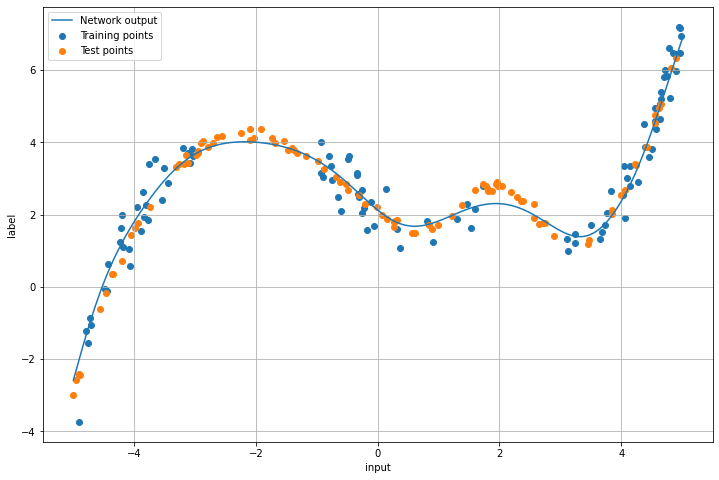

In [19]:
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.grid()
plt.legend()
plt.show()